# Sujet 2 : GCL RANDU

Moyano Axel 

Bonnassie Enzo

Grp 2A



On veut tester le GCL RANDU dont les caractéristiques sont les suivantes :

$
x_{n+1} \equiv 65539 \, x_n \pmod{2^{31}}, \quad x_0 = 12345
$

## À partir de ce GCL générer une suite de nombre dans l’intervalle [0,1].

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def normaliser(liste):
    minimum = min(liste)
    maximum = max(liste)

    newlist = []
    for i in liste :
        newlist.append((i - minimum) / (maximum - minimum))
    return newlist

def CGL_RANDU(nb_valeurs) :
    xn = 12345
    liste_valeurs = []
    
    for i in range(nb_valeurs) :
        xn1 = (65539 * xn)% (2**31)

        liste_valeurs.append(xn1)
        xn = xn1

    return normaliser(liste_valeurs)

def afficher_histogramme(liste) :
    plt.hist(liste, bins=5, edgecolor='black')
    plt.title("Histogramme des valeurs")
    plt.xlabel("Valeur")
    plt.ylabel("Fréquence")
    plt.show()
    

[0.3760847653561407, 0.25852465564691807, 0.1691756301589908, 0.6911224646144312, 0.5824918497109879, 0.2887527139756533, 0.5151066464514931, 0.47242961189711224, 0.20140843780198497, 0.9816011297343643, 0.013042146129923151, 0.32442578295101376, 0.7986263287489499, 0.8413768721467509, 0.8745280713795636, 0.6886803761962292, 0.2863466247577679, 0.5560865855338664, 0.7399640493523206, 0.4266823980350171, 0.9365481667925394, 0.7485983646522578, 0.08767369677715654, 0.8470135470596568, 0.22912931930513425, 0.8100106405609319, 0.7562377030747011, 0.2612342506394258, 0.8085096116744255, 0.4582871477470386, 0.5092666041657243, 0.9338058797537476, 1.0, 0.6096508794558778, 0.7051487122454467, 0.746824942852529, 0.13740183138890255, 0.15022993817083435, 0.6564405182507743, 0.5449113994224549, 0.3754075295173667, 0.36214637954171314, 0.797001096076727, 0.4921401067971191, 0.8159609988454943, 0.4470691908679277, 0.374896378351439, 0.2285461367800337, 0.0, 0.9569885662193034]


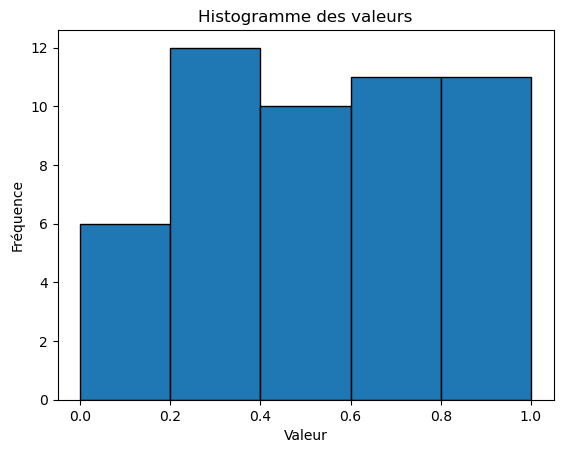

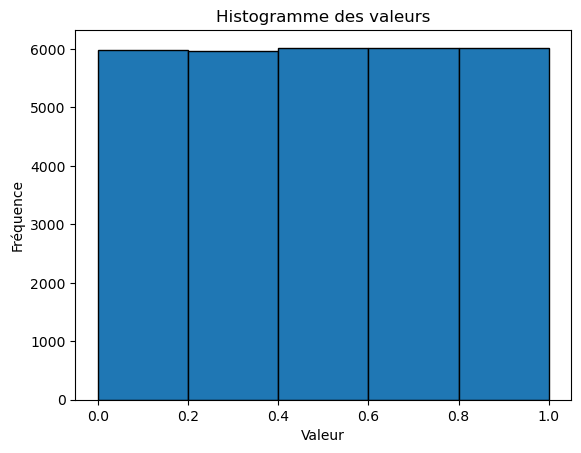

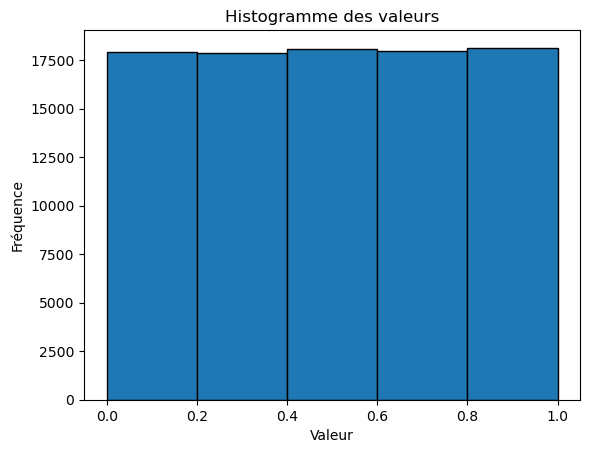

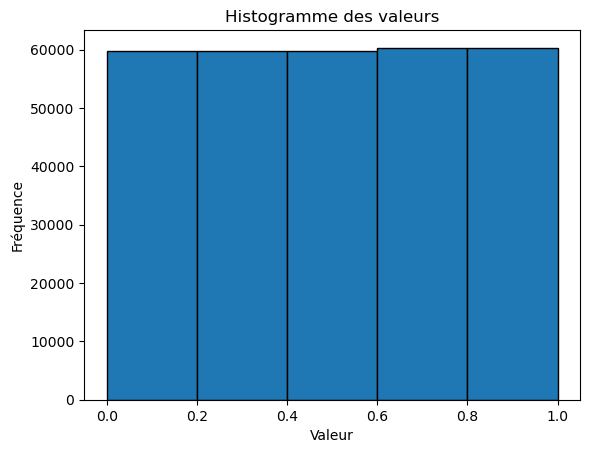

In [3]:
liste = CGL_RANDU(50)
liste2 = CGL_RANDU(30000)
liste3 = CGL_RANDU(90000)
liste4 = CGL_RANDU(300000)
print(liste)

afficher_histogramme(liste)
afficher_histogramme(liste2)
afficher_histogramme(liste3)
afficher_histogramme(liste4)


## Test du chi2

In [4]:
from scipy.stats import chisquare


def test_chi2(observed):
    # Nombre de classes (plus il y a de données, plus on peut en mettre)
    nb_classes = 10

    # Regroupement en classes (histogramme)
    counts, _ = np.histogram(observed, bins=nb_classes, range=(0, 1))

    # Distribution uniforme attendue
    expected = np.full(nb_classes, len(observed) / nb_classes)

    # Calcul du test du chi²
    chi2_stat, p_value = chisquare(f_obs=counts, f_exp=expected)

    # Seuil de confiance à 1 %
    alpha = 0.01

    # Affichage du résultat
    print(f"Statistique du chi² : {chi2_stat:.4f}")
    print(f"p-value : {p_value:.6f}")
    print("Résultat :", "Vrai (H0 acceptée)" if p_value > alpha else "Faux (H0 rejetée)")



In [6]:
# Exemple d'utilisation :
test_chi2(liste2)
test_chi2(liste3)
test_chi2(liste4)

Statistique du chi² : 6.9053
p-value : 0.646975
Résultat : Vrai (H0 acceptée)
Statistique du chi² : 8.8511
p-value : 0.451130
Résultat : Vrai (H0 acceptée)
Statistique du chi² : 5.4867
p-value : 0.789990
Résultat : Vrai (H0 acceptée)


## Test spectral 2D sur des doublets

In [7]:
# python
def spectral_test_2d(u, name="jeu", exp_var_threshold=0.80, dist_tol=1e-3, frac_threshold=0.02, plot=True):
    """
    Test spectral 2D sur doublets (u[i], u[i+1]).
    - u : liste ou array de valeurs dans [0,1]
    - exp_var_threshold : si la 1ere composante explique plus que ce seuil -> échec
    - dist_tol : distance seuil pour considérer un point "sur" l'axe principal
    - frac_threshold : fraction de points proches de l'axe au-dessus de laquelle on rejette
    Retourne (passed: bool, details: dict)
    """
    u = np.asarray(u)
    if len(u) < 2:
        raise ValueError("La suite doit contenir au moins 2 éléments.")
    pts = np.column_stack((u[:-1], u[1:]))
    N = pts.shape[0]

    # centrage
    mean = pts.mean(axis=0)
    centered = pts - mean

    # SVD / PCA
    U, S, Vt = np.linalg.svd(centered, full_matrices=False)
    s1, s2 = S[0], S[1]
    explained_var1 = (s1**2) / (s1**2 + s2**2)

    # vecteur unitaire de la 1ère composante
    v1 = Vt[0]
    # distances des points à l'axe principal
    proj_lengths = centered.dot(v1)[:, None] * v1[None, :]
    residuals = centered - proj_lengths
    dists = np.linalg.norm(residuals, axis=1)

    frac_close = np.mean(dists <= dist_tol)

    # décision simple combinée
    fail_reason = []
    if explained_var1 > exp_var_threshold:
        fail_reason.append(f"Variance expliquée élevée: {explained_var1:.3f} > {exp_var_threshold}")
    if frac_close > frac_threshold:
        fail_reason.append(f"Proportion de points alignés élevée: {frac_close:.3f} > {frac_threshold}")

    passed = len(fail_reason) == 0

    # Affichage / diagnostic
    verdict = "PASSÉ" if passed else "ÉCHOUÉ"
    print(f"Test spectral 2D pour {name} : {verdict}")
    print(f"  Points : {N}")
    print(f"  Variance expliquée (1ère composante) : {explained_var1:.4f}")
    print(f"  Proportion de points à distance ≤ {dist_tol} : {frac_close:.4f}")
    if not passed:
        for r in fail_reason:
            print("  -", r)

    if plot:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.scatter(pts[:,0], pts[:,1], s=6, alpha=0.6)
        ax.set_title(f"Nuage des doublets ({name}) — {verdict}")
        ax.set_xlabel(r"$u_n$")
        ax.set_ylabel(r"$u_{n+1}$")
        ax.set_aspect('equal', 'box')

        # tracer l'axe principal (droite passant par la moyenne selon v1)
        t = np.linspace(-0.5, 0.5, 2)
        line_pts = mean + np.outer(t, v1)
        ax.plot(line_pts[:,0], line_pts[:,1], color='red', linewidth=2, label='1ère composante')
        ax.legend()
        plt.show()

    details = {
        "N": N,
        "explained_var1": explained_var1,
        "frac_close": frac_close,
        "passed": passed,
        "fail_reasons": fail_reason,
        "v1": v1,
        "mean": mean
    }
    return passed, details


Test spectral 2D pour liste2 : PASSÉ
  Points : 29999
  Variance expliquée (1ère composante) : 0.5030
  Proportion de points à distance ≤ 0.001 : 0.0029


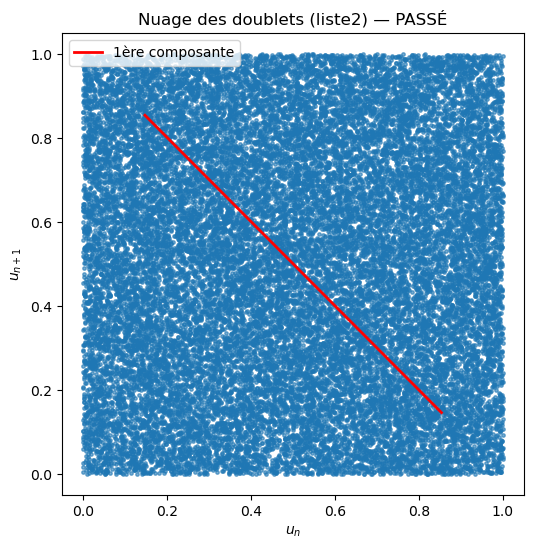

Test spectral 2D pour liste3 : PASSÉ
  Points : 89999
  Variance expliquée (1ère composante) : 0.5005
  Proportion de points à distance ≤ 0.001 : 0.0029


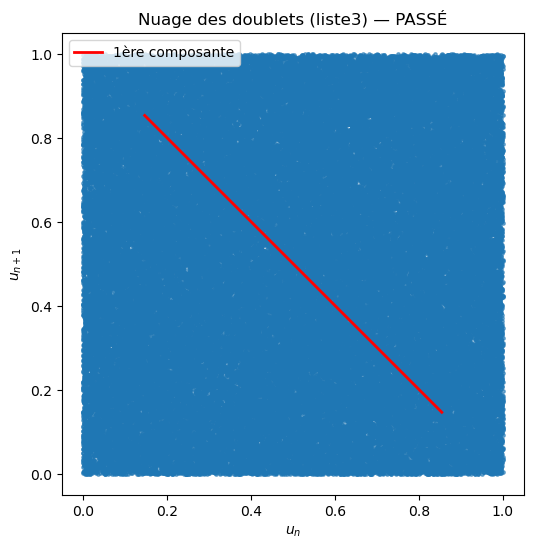

Test spectral 2D pour liste4 : PASSÉ
  Points : 299999
  Variance expliquée (1ère composante) : 0.5013
  Proportion de points à distance ≤ 0.001 : 0.0031


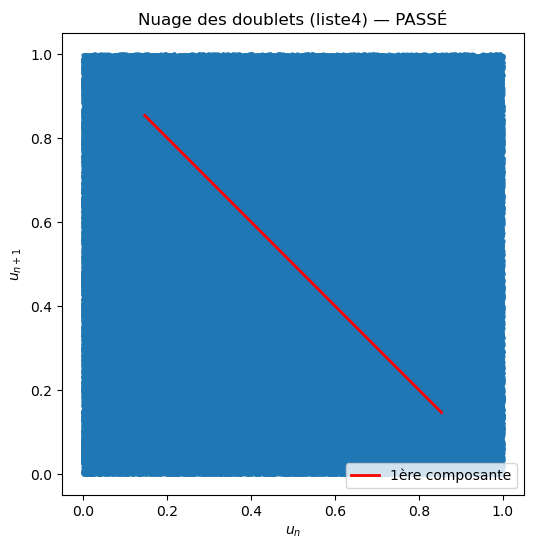

(True,
 {'N': 299999,
  'explained_var1': np.float64(0.5013402541368955),
  'frac_close': np.float64(0.0030533435111450373),
  'passed': True,
  'fail_reasons': [],
  'v1': array([ 0.70676684, -0.70744655]),
  'mean': array([0.5008064 , 0.50080555])})

In [8]:
# Exemple d'utilisation (avec les listes déjà générées dans le notebook) :
spectral_test_2d(liste2, name="liste2", plot=True)
spectral_test_2d(liste3, name="liste3", plot=True)
spectral_test_2d(liste4, name="liste4", plot=True)

## Test spectral 3D sur des triplets

In [9]:

from mpl_toolkits.mplot3d import Axes3D

def spectral_test_3d(u, name="jeu", exp_var1_threshold=0.90, exp_var12_threshold=0.98,
                     dist_line_tol=1e-3, dist_plane_tol=1e-3,
                     frac_line_threshold=0.02, frac_plane_threshold=0.02, plot=True):
    """
    Test spectral 3D sur triplets (u[i], u[i+1], u[i+2]).
    - u : liste/array de valeurs dans [0,1]
    - exp_var1_threshold : seuil si la 1ere composante explique trop -> structure 'ligne'
    - exp_var12_threshold : seuil si 2 premières expliquent trop -> structure 'plan'
    - dist_line_tol / dist_plane_tol : distances seuil pour considérer un point sur la droite/plan
    - frac_line_threshold / frac_plane_threshold : fraction de points au-dessus de laquelle on rejette
    Retourne (passed: bool, details: dict)
    """
    u = np.asarray(u)
    if len(u) < 3:
        raise ValueError("La suite doit contenir au moins 3 éléments.")
    pts = np.column_stack((u[:-2], u[1:-1], u[2:]))
    N = pts.shape[0]

    mean = pts.mean(axis=0)
    centered = pts - mean

    # PCA via SVD
    U, S, Vt = np.linalg.svd(centered, full_matrices=False)
    s1, s2, s3 = S[0], S[1], S[2]
    total_var = s1**2 + s2**2 + s3**2
    explained_var1 = (s1**2) / total_var
    explained_var12 = (s1**2 + s2**2) / total_var

    v1 = Vt[0]
    v2 = Vt[1]

    # distances à la droite (v1)
    proj_line = centered.dot(v1)[:, None] * v1[None, :]
    resid_line = centered - proj_line
    dists_line = np.linalg.norm(resid_line, axis=1)
    frac_line = np.mean(dists_line <= dist_line_tol)

    # distances au plan (span{v1, v2})
    proj_plane = (centered.dot(v1)[:, None] * v1[None, :]) + (centered.dot(v2)[:, None] * v2[None, :])
    resid_plane = centered - proj_plane
    dists_plane = np.linalg.norm(resid_plane, axis=1)
    frac_plane = np.mean(dists_plane <= dist_plane_tol)

    fail_reason = []
    if explained_var1 > exp_var1_threshold:
        fail_reason.append(f"Ligne (variance 1\ère comp élevée): {explained_var1:.4f} > {exp_var1_threshold}")
    if explained_var12 > exp_var12_threshold:
        fail_reason.append(f"Plan (2 premières comps expliquent beaucoup): {explained_var12:.4f} > {exp_var12_threshold}")
    if frac_line > frac_line_threshold:
        fail_reason.append(f"Proportion de points sur une droite élevée: {frac_line:.4f} > {frac_line_threshold}")
    if frac_plane > frac_plane_threshold:
        fail_reason.append(f"Proportion de points sur un plan élevée: {frac_plane:.4f} > {frac_plane_threshold}")

    passed = len(fail_reason) == 0
    verdict = "PASSÉ" if passed else "ÉCHOUÉ"

    print(f"Test spectral 3D pour {name} : {verdict}")
    print(f"  Points : {N}")
    print(f"  Variance expliquée (1\ère comp) : {explained_var1:.4f}")
    print(f"  Variance expliquée (1+2 comps) : {explained_var12:.4f}")
    print(f"  Frac sur droite (d ≤ {dist_line_tol}) : {frac_line:.4f}")
    print(f"  Frac sur plan (d ≤ {dist_plane_tol}) : {frac_plane:.4f}")
    if not passed:
        for r in fail_reason:
            print("  -", r)

    if plot:
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=6, alpha=0.6)
        ax.set_title(f"Triplets ({name}) — {verdict}")
        ax.set_xlabel('u_n'); ax.set_ylabel('u_{n+1}'); ax.set_zlabel('u_{n+2}')

        # tracer la droite principale
        t = np.linspace(-0.6, 0.6, 2)
        line_pts = mean + np.outer(t, v1)
        ax.plot(line_pts[:,0], line_pts[:,1], line_pts[:,2], color='red', linewidth=2, label='1ère composante (droite)')

        # tracer un patch de plan principal
        s_vals = np.linspace(-0.3, 0.3, 10)
        t_vals = np.linspace(-0.3, 0.3, 10)
        Sg, Tg = np.meshgrid(s_vals, t_vals)
        plane_pts = mean[None, None, :] + Sg[..., None]*v1[None, None, :] + Tg[..., None]*v2[None, None, :]
        ax.plot_surface(plane_pts[...,0], plane_pts[...,1], plane_pts[...,2],
                        color='orange', alpha=0.25, rstride=1, cstride=1, linewidth=0)

        ax.legend()
        plt.show()

    details = {
        "N": N,
        "explained_var1": explained_var1,
        "explained_var12": explained_var12,
        "frac_line": frac_line,
        "frac_plane": frac_plane,
        "passed": passed,
        "fail_reasons": fail_reason,
        "v1": v1,
        "v2": v2,
        "mean": mean
    }
    return passed, details

Test spectral 3D pour liste2 : PASSÉ
  Points : 29998
  Variance expliquée (1\ère comp) : 0.3378
  Variance expliquée (1+2 comps) : 0.6692
  Frac sur droite (d ≤ 0.001) : 0.0000
  Frac sur plan (d ≤ 0.001) : 0.0031


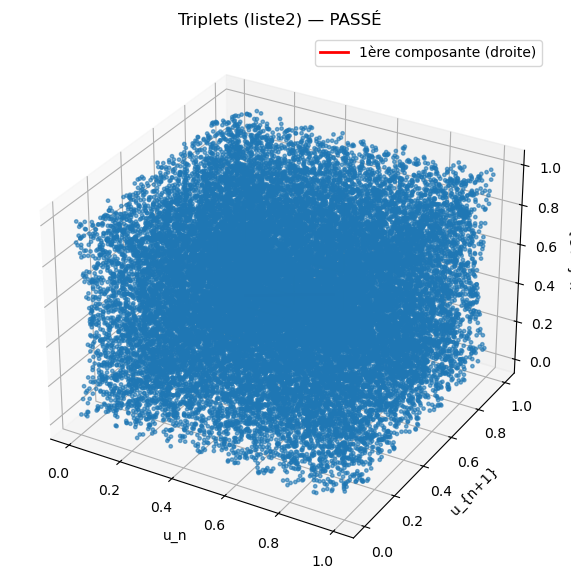

Test spectral 3D pour liste3 : PASSÉ
  Points : 89998
  Variance expliquée (1\ère comp) : 0.3341
  Variance expliquée (1+2 comps) : 0.6672
  Frac sur droite (d ≤ 0.001) : 0.0000
  Frac sur plan (d ≤ 0.001) : 0.0028


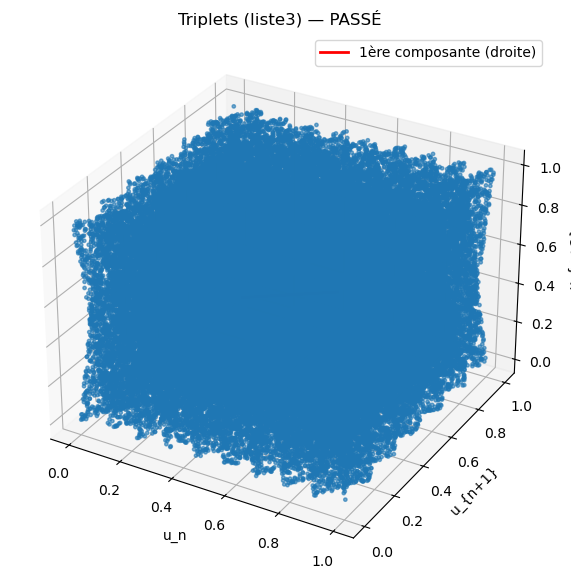

Test spectral 3D pour liste4 : PASSÉ
  Points : 299998
  Variance expliquée (1\ère comp) : 0.3342
  Variance expliquée (1+2 comps) : 0.6684
  Frac sur droite (d ≤ 0.001) : 0.0000
  Frac sur plan (d ≤ 0.001) : 0.0026


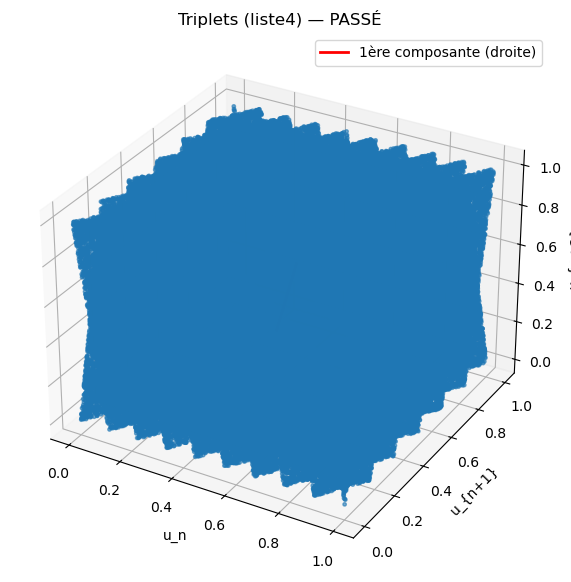

(True,
 {'N': 299998,
  'explained_var1': np.float64(0.3342395868908791),
  'explained_var12': np.float64(0.668429250397689),
  'frac_line': np.float64(0.0),
  'frac_plane': np.float64(0.0025600170667804453),
  'passed': True,
  'fail_reasons': [],
  'v1': array([-0.4063602 ,  0.81253898, -0.41791362]),
  'v2': array([-0.71038427,  0.00670519,  0.70378209]),
  'mean': array([0.50080652, 0.50080682, 0.50080635])})

In [10]:
# Exemple d'utilisation (avec les listes déjà générées dans le notebook) :
spectral_test_3d(liste2, name="liste2", plot=True)
spectral_test_3d(liste3, name="liste3", plot=True)
spectral_test_3d(liste4, name="liste4", plot=True)